<a href="https://colab.research.google.com/github/lwerth/INFO510-public/blob/master/info510_hmwk4_question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regression with many explanatory variables: Table 15.2 displays data from a designed experiment for a chemical process. In using these data to illustrate various approaches to selection and estimation of regression coefficients, Marquardt and Snee (1975) assume a quadratic regression form; that is, a linear relation between the expectation of the untransformed outcome, y, and the variables $x_1, x_2, x_3$, their two-way interactions, $x_1x_2, x_1x_3, x_2x_3$, and their squares, $x_2^{1}, x_2^{2}, x_2^{3}$.

## 3
(a) Fit an ordinary linear regression model (that is, nonhierarchical with a uniform prior distribution on the coefficients), including a constant term and the nine explanatory variables above.

In [2]:
# ! pip install pymc3 --upgrade
# ! pip install arviz

In [3]:
import numpy as np, scipy as sp, pymc3 as pm, matplotlib.pyplot as plt, pandas as pd, theano, theano.tensor as tt
from scipy import stats
import seaborn as sb
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import arviz as az

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

import theano

In [4]:
chemical = pd.read_csv('/content/drive/My Drive/Fall 2020/info510/hwk4/chemical.csv')
chemical.head()

chem_blocks = chemical.x1.unique()
chem_idx = OrdinalEncoder(dtype = np.int64).fit_transform(chemical[['x1']])
n_chem = len(chemical.x1.unique())

chemical.head()

,x1,x2,x3,y
0,1300,7.5,0.0120,49.0
1,1300,9.0,0.0120,50.2
2,1300,11.0,0.0115,50.5
3,1300,13.5,0.0130,48.5
4,1300,17.0,0.0135,47.5


In [6]:
#create a data frame with the 9 explanatory variables

variables = chemical.drop('y', axis=1)
variables['x1x2'] = variables.x1.multiply(variables.x2)
variables['x1x3'] = variables.x1.multiply(variables.x3)
variables['x2x3'] = variables.x2.multiply(variables.x3)
variables['x1_2'] = variables.x1**2
variables['x2_2'] = variables.x2**2
variables['x3_2'] = variables.x3**2
variables

#create another dataframe of the 9 explanatory variables and the outcome, y - all standardized
chem_var = variables.join(chemical.y)
chem_var[['y']] = StandardScaler().fit_transform(chem_var[['y']])
chem_var[['x1']] = StandardScaler().fit_transform(chem_var[['x1']])
chem_var[['x2']] = StandardScaler().fit_transform(chem_var[['x2']])
chem_var[['x3']] = StandardScaler().fit_transform(chem_var[['x3']])
chem_var[['x1x2']] = StandardScaler().fit_transform(chem_var[['x1x2']])
chem_var[['x1x3']] = StandardScaler().fit_transform(chem_var[['x1x3']])
chem_var[['x2x3']] = StandardScaler().fit_transform(chem_var[['x2x3']])
chem_var[['x1_2']] = StandardScaler().fit_transform(chem_var[['x1_2']])
chem_var[['x2_2']] = StandardScaler().fit_transform(chem_var[['x2_2']])
chem_var[['x3_2']] = StandardScaler().fit_transform(chem_var[['x3_2']])

n_var = len(chem_var.y.unique())
print(variables)
print(chem_var)


      x1    x2      x3     x1x2    x1x3    x2x3     x1_2    x2_2      x3_2
0   1300   7.5  0.0120   9750.0   15.60  0.0900  1690000   56.25  0.000144
1   1300   9.0  0.0120  11700.0   15.60  0.1080  1690000   81.00  0.000144
2   1300  11.0  0.0115  14300.0   14.95  0.1265  1690000  121.00  0.000132
3   1300  13.5  0.0130  17550.0   16.90  0.1755  1690000  182.25  0.000169
4   1300  17.0  0.0135  22100.0   17.55  0.2295  1690000  289.00  0.000182
5   1300  23.0  0.0120  29900.0   15.60  0.2760  1690000  529.00  0.000144
6   1200   5.3  0.0400   6360.0   48.00  0.2120  1440000   28.09  0.001600
7   1200   7.5  0.0380   9000.0   45.60  0.2850  1440000   56.25  0.001444
8   1200  11.0  0.0320  13200.0   38.40  0.3520  1440000  121.00  0.001024
9   1200  13.5  0.0260  16200.0   31.20  0.3510  1440000  182.25  0.000676
10  1200  17.0  0.0340  20400.0   40.80  0.5780  1440000  289.00  0.001156
11  1200  23.0  0.0410  27600.0   49.20  0.9430  1440000  529.00  0.001681
12  1100   5.3  0.0840   

In [7]:
#vari = theano.shared(chem_var.loc[:,'x1':'x3_2'].values)
  # sigma = pm.HalfCauchy('sigma', 5)
  # b = pm.Flat('b', shape =9)

with pm.Model() as ord_model:
  # parameter proirs
  alpha = pm.Normal('alpha', 0, .2) # for some reason I set the alpha to 1 and it was taking much longer than I needed, hopefully .2 works
  sigma = pm.Exponential('sigma', 1)
  b = pm.Normal('b', 0, .5, shape=9) #use for each explanatory variable - I had this at 1 and it was KILLING my sampling!! 

# Model equation and observation
  mu = pm.Deterministic('mu', alpha + b[0]*chem_var.x1 + b[1]*chem_var.x2 + b[2]*chem_var.x3 + b[3]*chem_var.x1x2 +  b[4]*chem_var.x1x3 + b[5]*chem_var.x2x3 + b[6]*chem_var.x1_2 + b[7]*chem_var.x2_2 + b[8]*chem_var.x3_2)
  y = pm.Normal('y', mu, sigma, observed=chem_var.y) #chem_var.y


In [8]:
#played around with different tune and target acceptance rates
with ord_model:
    trace_1 = pm.sample(2000,  init='advi', cores = 2, tune=2000, target_accept = .95)
    trace_1_sum = pm.summary(trace_1)

trace_1_sum

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 7300
Interrupted at 7,299 [3%]: Average Loss = 66.942
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, sigma, alpha]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.001,0.055,-0.102,0.101,0.001,0.001,5332.0,1028.0,5299.0,2230.0,1.0
b[0],0.396,0.381,-0.342,1.085,0.008,0.006,2480.0,2128.0,2486.0,2302.0,1.0
b[1],0.180,0.382,-0.511,0.906,0.008,0.006,2152.0,2009.0,2152.0,2401.0,1.0
b[2],-0.209,0.432,-1.024,0.584,0.009,0.007,2444.0,1967.0,2443.0,2482.0,1.0
b[3],0.034,0.378,-0.701,0.715,0.008,0.006,2173.0,1966.0,2173.0,2265.0,1.0
b[4],-0.175,0.405,-0.966,0.550,0.008,0.007,2466.0,1791.0,2470.0,2123.0,1.0
b[5],0.229,0.148,-0.067,0.502,0.002,0.002,4028.0,3236.0,4031.0,2578.0,1.0
b[6],0.397,0.369,-0.270,1.108,0.007,0.006,2594.0,2129.0,2600.0,2254.0,1.0
b[7],-0.248,0.256,-0.737,0.234,0.004,0.003,3520.0,3218.0,3559.0,2914.0,1.0
b[8],0.025,0.288,-0.522,0.564,0.005,0.004,3095.0,2066.0,3113.0,2844.0,1.0


## 4
(b) Fit a mixed-effects linear regression model with a uniform prior distribution on the constant term and a shared normal prior distribution on the coefficients of the nine variables above. If you use iterative simulation in your computations, be sure to use multiple sequences and monitor their joint convergence.

In [12]:
var_idx = OrdinalEncoder(dtype = np.int64).fit_transform(chem_var[['x1']])

with pm.Model() as hierarchical_mdl:
  alpha = pm.Normal('alpha', .2) #noninformative priors 1
  sigma = pm.HalfCauchy('sigma', 1)
  tau_delta = pm.Flat('tau_delta')

  temp = theano.shared(var_idx)
  data = theano.shared(chem_var.loc[:, 'x1':'x3_2'].values)
  beta = pm.Normal('beta', 0, .5, shape=9)
  delta = pm.Normal('delta', 0, tau_delta, shape = 16)

  mu = pm.Deterministic('mu', alpha + tt.dot(data, beta) + tt.dot(temp, delta)) #chem_var.x1, x1 is the constant variable in the dataset, it looks at 3 different types of temperatures

  y = pm.Normal('y', mu, sigma, observed = chem_var.y)


ValueError: ignored

In [ ]:
with hierarchical_mdl:
    trace_2 = pm.sample(2000,  init='advi', cores = 2, tune=4000, target_accept = .99)
    trace_2_sum = pm.summary(trace_2)

trace_2_sum

##use summary table to get the t-statistic

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 12500
Interrupted at 12,499 [6%]: Average Loss = 1.3076e+05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [delta, beta, tau_delta, sigma, alpha]


Sampling 2 chains for 4_000 tune and 2_000 draw iterations (8_000 + 4_000 draws total) took 1481 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,14.840,47.698,-86.112,96.324,10.366,8.235,21.0,17.0,21.0,27.0,1.09
sigma,0.239,0.063,0.141,0.350,0.002,0.001,1215.0,1150.0,1454.0,1613.0,1.00
tau_delta,18.171,11.403,0.070,37.782,2.532,1.816,20.0,20.0,21.0,53.0,1.05
beta[0],0.362,0.741,-0.956,1.854,0.012,0.013,3595.0,1728.0,3606.0,2000.0,1.00
beta[1],-0.316,0.821,-1.850,1.254,0.013,0.014,3749.0,1622.0,3766.0,2479.0,1.00
beta[2],-0.102,0.721,-1.570,1.197,0.012,0.013,3796.0,1540.0,3784.0,2726.0,1.00
beta[3],-0.130,0.744,-1.598,1.166,0.012,0.012,4070.0,1921.0,4074.0,2729.0,1.00
beta[4],0.226,0.196,-0.137,0.598,0.003,0.003,3445.0,2630.0,3420.0,2690.0,1.00
beta[5],0.785,0.310,0.160,1.339,0.005,0.003,4220.0,4172.0,4227.0,3083.0,1.00
beta[6],-0.300,0.359,-0.981,0.375,0.006,0.005,4057.0,2612.0,4092.0,2866.0,1.00


In [ ]:
pm.traceplot(trace_2)

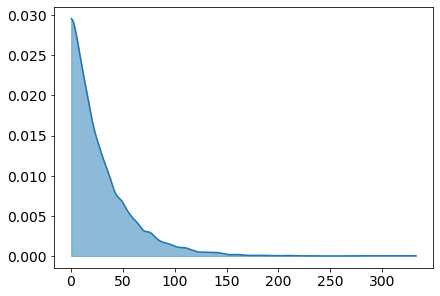

In [ ]:
with hierarchical_mdl:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), fill_kwargs={'alpha': 0.5});

In [ ]:
with hierarchical_mdl:
  distb_mean = pm.Exponential('distb_mean', 1/29.) + 1
  t_test = pm.StudentT('t_test', nu = ν_distb_mean, mu = trace_2_sum['mcse_mean'], lam = trace_2_sum['mcse_sd'])
t_test

TypeError: ignored

In [ ]:
def pairplot_divergence(trace_2, ax=None, divergence=True, color='C3', divergence_color='C2'):
    theta = trace_2.get_values(varname='theta', combine=True)[:, 0]
    logtau = trace_2.get_values(varname='tau_log__', combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace_2['diverging']
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel('theta[0]')
    ax.set_ylabel('log(tau)')
    ax.set_title('scatter plot between log(tau) and theta[0]');
    return ax

pairplot_divergence(trace_2)

In [ ]:
for i in chem_var.y:
  conversion = np.tile(t


##5
Discuss the differences between the inferences in (a) and (b). Interpret the differences in terms of the hierarchical variance parameter. Do you agree with Marquardt and Snee that the inferences from (a) are unacceptable?

(a), the ordinary linear regression model ignores the affects each treatment has on each other and treats them as 16 independent instead of 3 sets of temperature variables with about 5 observations in each. Because each treatment is seen as indepentent, the model is prone to overfitting. Using a hierarchcal variance parameter allows correlation within the explanatory variables, and is less prone to positive extremes (overfitting). Hierarchcal variance also shows different components of variability for each temperature which is indicative of stronger reliability. 

## 6
(d) Repeat (a), but with a t4 prior distribution on the nine variables.

NameError: ignored

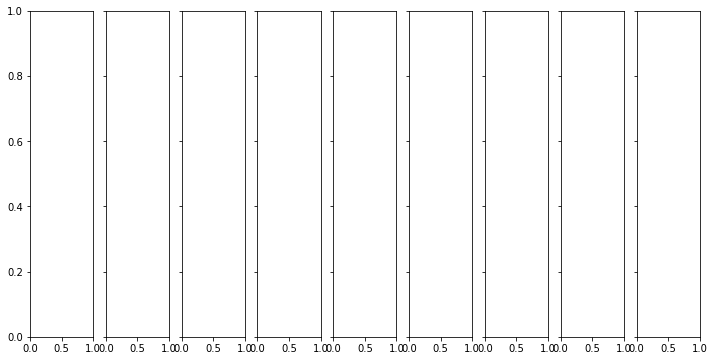

In [ ]:
selection = ['x1', 'x2', 'x3','x1x2','x1x3','x2x3','x1_2','x2_3','x3_2']
fig, axis = plt.subplots(1, 9, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    t_data = chem_var[chem_var.x1 == t]
    t_data = t_data.reset_index(drop=True)
    t_index = np.where(x1 == t)[0][0]
    z = list(t_data['x1'])[0]

    xvals = np.linspace(-0.2, 1.2)
    for a_val, b_val in zip(trace_1['a'][:, t_index], trace_1['b'][:, t_index]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'b', alpha=.1)
    axis[i].plot(xvals, trace_1['a'][:, c_index].mean() + trace_1['b'][:, c_index].mean() * xvals,
                 'b', alpha=1, lw=2., label='individual')
    for a_val, b_val in zip(trace_2['a'][z], trace_2['b'][z]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'g', alpha=.1)
    axis[i].plot(xvals, trace_2['a'][z].mean() + trace_2['b'][z].mean() * xvals,
                 'g', alpha=1, lw=2., label='hierarchical')
    axis[i].scatter(t_data.floor + np.random.randn(len(t_data))*0.01, t_data.y,
                    alpha=1, color='k', marker='.', s=80, label='original data')
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(['basement', 'no basement'])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i % 3:
        axis[i].legend()
        axis[i].set_ylabel('log radon level')

In [ ]:
# var_ = pd.DataFrame(dict(value=np.r_[chem_var.x1, x2, x3, x1x2, x1x3, x2x3, x1_2, x2_2, x3_2], group=np.r_[['x1']*len(x1), ['placebo']*len(placebo)]))

# I know there's an easier way to do this but I am at a loss at the moment.


#calculate mean for each explanatory vairable

μ_m = vari.mean()
μ_s = vari.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', mu=μ_m, sd=μ_s)
    group3_mean = pm.Normal('group3_mean', mu=μ_m, sd=μ_s)
    group4_mean = pm.Normal('group4_mean', mu=μ_m, sd=μ_s)
    group5_mean = pm.Normal('group5_mean', mu=μ_m, sd=μ_s)
    group6_mean = pm.Normal('group6_mean', mu=μ_m, sd=μ_s)
    group7_mean = pm.Normal('group7_mean', mu=μ_m, sd=μ_s)
    group8_mean = pm.Normal('group8_mean', mu=μ_m, sd=μ_s)
    group9_mean = pm.Normal('group9_mean', mu=μ_m, sd=μ_s)

In [ ]:
σ_low = 1
σ_high = 10

#calculate std for each explanatory vairable with a uniform prior of (1,10)


with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)
    group3_std = pm.Uniform('group3_std', lower=σ_low, upper=σ_high)
    group4_std = pm.Uniform('group4_std', lower=σ_low, upper=σ_high)
    group5_std = pm.Uniform('group5_std', lower=σ_low, upper=σ_high)
    group6_std = pm.Uniform('group6_std', lower=σ_low, upper=σ_high)
    group7_std = pm.Uniform('group7_std', lower=σ_low, upper=σ_high)
    group8_std = pm.Uniform('group8_std', lower=σ_low, upper=σ_high)
    group9_std = pm.Uniform('group9_std', lower=σ_low, upper=σ_high)


In [ ]:
#transform the std to work with the precison terms to specify our likelihoods

with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2
    λ3 = group3_std**-2
    λ4 = group4_std**-2
    λ5 = group5_std**-2
    λ6 = group6_std**-2
    λ7 = group7_std**-2
    λ8 = group8_std**-2
    λ9 = group9_std**-2

    group1 = pm.StudentT('group1', nu=ν, mu=group1_mean, lam=λ1, observed=chem_var.x1)
    group2 = pm.StudentT('group2', nu=ν, mu=group2_mean, lam=λ2, observed=chem_var.x2)
    group3 = pm.StudentT('group3', nu=ν, mu=group3_mean, lam=λ1, observed=chem_var.x3)
    group4 = pm.StudentT('group4', nu=ν, mu=group4_mean, lam=λ4, observed=chem_var.x1x2)
    group5 = pm.StudentT('group5', nu=ν, mu=group5_mean, lam=λ5, observed=chem_var.x1x3)
    group6 = pm.StudentT('group6', nu=ν, mu=group6_mean, lam=λ6, observed=chem_var.x2x3)
    group7 = pm.StudentT('group7', nu=ν, mu=group7_mean, lam=λ7, observed=chem_var.x1_2)
    group8 = pm.StudentT('group8', nu=ν, mu=group8_mean, lam=λ8, observed=chem_var.x2_2)
    group9 = pm.StudentT('group9', nu=ν, mu=group9_mean, lam=λ9, observed=chem_var.x3_2)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν_minus_one, group9_std, group8_std, group7_std, group6_std, group5_std, group4_std, group3_std, group2_std, group1_std, group9_mean, group8_mean, group7_mean, group6_mean, group5_mean, group4_mean, group3_mean, group2_mean, group1_mean]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 470 seconds.
The acceptance probability does not match the target. It is 0.26280840882887546, but should be close to 0.8. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 7.424164075851339e-58, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
with model:
    trace = pm.sample(2000)
    trace_sum = pm.summary(trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


KeyboardInterrupt: ignored

In [ ]:
pm.plot_posterior(trace)

### Extra

In [ ]:



  # mu = alpha + b[chem_var.x1] + b[chem_var.x2] + b[chem_var.x3] + b[chem_var.x1x2] + b[chem_var.x1x3] + b[chem_var.x2x3] + b[chem_var.x1_2] + b[chem_var.x2_2] + b[chem_var.x3_2]

  # b_x1 = pm.Normal('b_x1', 0, 1, shape = n_var)
  # b_x2 = pm.Normal('b_x2', 0, 1, shape = n_var)
  # b_x3 = pm.Normal('b_x3', 0, 1, shape = n_var)
  # b_x1x2 = pm.Normal('b_x1x2', 0, 1, shape = n_var)
  # b_x1x3 = pm.Normal('b_x1x3', 0, 1, shape = n_var)
  # b_x2x3 = pm.Normal('b_x2x3', 0, 1, shape = n_var)
  # b_x1_2 = pm.Normal('b_x1_2', 0, 1, shape = n_var)
  # b_x2_2 = pm.Normal('b_x2_2', 0, 1, shape = n_var)
  # b_x3_2 = pm.Normal('b_x3_2', 0, 1, shape = n_var)

  # mu = alpha + tt.dot(b_x1, chem_var.x1) + tt.dot(b_x2, chem_var.x2)
  # + tt.dot(b_x3, chem_var.x3) + tt.dot(b_x1x2, chem_var.x1x2) + tt.dot(b_x1x3, chem_var.x1x3)
  # + tt.dot(b_x2x3, chem_var.x2x3) +tt.dot(b_x1_2, chem_var['x1^2']) +tt.dot(b_x2_2, chem_var['x2^2'])
  # + tt.dot(b_x3_2, chem_var['x3^2'])

In [ ]:
# Replicate the posterior predictive check from BDA section 15.2

def make_pooled_ppc(trace, data):
    # Sample from the posterior predictive distribution for each year
    with logistic_model:
    ppc = pm.sample_posterior_predictive(trace_1, var_names=["y", 'alpha']
    )

    rmse= np.array([np.average()])
    # reps_dict = {}
    # for year in np.arange(1948, 1992, 4):
    #     with setup_pooled_model(train[train.year == year]) as test_model: 
    #         ppc = pm.sample_posterior_predictive(train_trace)
    #         reps_dict[year] = ppc['y']
    
    # Calculate residuals: replications vs. observations
    # rep_resid = {}
    # pred_resid = {}
    # nrep = reps_dict[1948].shape[0]
    # for year in np.arange(1948, 1992, 4):
    #     thisyear_dvote = np.tile(train[train.year == year]['dvote'], (2000,1))
    #     rep_resid[year] = reps_dict[year][:, :] - train_trace['mu'][:,train.year == year]
    #     pred_resid[year] = thisyear_dvote - train_trace['mu'][:,train.year == year]
    
    # Mean squared residuals
    sq_rep_resid_array = np.array([np.average(rep_resid[year], axis = 1) ** 2 for year in np.arange(1948, 1992, 4)])
    sq_pred_resid_array = np.array([np.average(pred_resid[year], axis = 1) ** 2 for year in np.arange(1948, 1992, 4)])
    
    # Final test statistics
    trep = np.sqrt(np.sum(sq_rep_resid_array, axis = 0))
    t = np.sqrt(np.sum(sq_pred_resid_array, axis = 0))
    
    #Make the plot
    plt.plot(t, trep, '.', color = 'blue', alpha = 0.3)
    plt.plot(np.linspace(0, 0.05, 5), np.linspace(0, 0.05, 5), color = 'red')
    plt.show()

In [ ]:
with pm.Model() as model_1:

    # Independent parameters for each county
    a = pm.Normal('a', 0, sigma=100, shape=n_chem)
    b = pm.Normal('b', 0, sigma=100, shape=n_chem)

    # Model error
    eps = pm.HalfCauchy('eps', 5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    chem_est = a[chem_idx] + b[chem_idx]*chemical.y.values

    # Data likelihood
    y = pm.Normal('y', chem_est, sigma=eps, observed=chemical.y)

In [ ]:
# with model_1:
#     trace_1 = pm.sample(2000)
#     trace_1_sum = pm.summary(trace_1)

# trace_1_sum

In [ ]:
with pm.Model() as unpooled_model:

    # Independent parameters for each block
    ba = pm.Normal('ba', 0, sigma=100, shape=n_pen)
    bb = pm.Normal('bb', 0, sigma=100, shape=n_pen)
    bc = pm.Normal('bc', 0, sigma=100, shape=n_pen)
    bd = pm.Normal('bd', 0, sigma=100, shape=n_pen)


    # Model error
    eps = pm.HalfCauchy('eps', 5)

    # Model prediction of treatments level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county to its coefficients.
    treat_est = ba[pen_idx] + bb[pen_idx] + bc[pen_idx]*penecillin.D.values

    # Data likelihood
    y = pm.Normal('y', treat_est, sigma=eps, observed=penecillin.mean)



# Fully pooled; simple logistic regression

# with pm.Model() as log_model:
#     a = pm.Normal('a', 0, 2, shape = n_pen)
#     b = pm.Normal('b', 0, 1, shape = n_pen)
#     sigma = pm.HalfCauchy('sigma', 5)
#     mu = pm.math.invlogit(a + b[pen_idx] * pen_idx)
#     score = pm.Normal('score', mu=mu, observed = "penecillin.D, penecillin.C, penecillin.B",)

    trace_simple = pm.sample(2000, target_accept = 0.95, tune = 1000)
    summary_simple = pm.summary(trace_simple)

TypeError: ignored